In [1]:
import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import isolearn.keras as iso

import scipy.optimize as spopt
from scipy.stats import pearsonr

#Logistic regression prediction
def get_y_pred(X, w, w_0) :
    return 1. / (1. + np.exp(-1. * (X.dot(w) + w_0)))

#Safe log for NLL
def safe_log(x, minval=0.01):
    return np.log(x.clip(min=minval))

#Logistic regression NLL loss
def log_loss(w_bundle, *fun_args) :
    (X, y, lambda_penalty) = fun_args
    w = w_bundle[1:]
    w_0 = w_bundle[0]
    N = float(X.shape[0])

    log_y_zero = safe_log(1. - get_y_pred(X, w, w_0))
    log_y_one = safe_log(get_y_pred(X, w, w_0))

    log_loss = (1. / 2.) * lambda_penalty * np.square(np.linalg.norm(w)) - (1. / N) * np.sum(y * log_y_one + (1. - y) * log_y_zero)

    return log_loss

#Logistic regression NLL gradient
def log_loss_gradient(w_bundle, *fun_args) :
    (X, y, lambda_penalty) = fun_args
    w = w_bundle[1:]
    w_0 = w_bundle[0]
    N = float(X.shape[0])

    y_pred = get_y_pred(X, w, w_0)

    w_0_gradient = - (1. / N) * np.sum(y - y_pred)
    w_gradient = 1. * lambda_penalty * w - (1. / N) * X.T.dot(y - y_pred)

    return np.concatenate([[w_0_gradient], w_gradient])


Using TensorFlow backend.


In [2]:
#Load 5'ss plasmid data
plasmid_dict = pickle.load(open('../data/a5ss/processed_data/alt_5ss_data.pickle', 'rb'))

#Generate training and test set indexes
valid_set_size=0.05
test_set_size=0.05

plasmid_index = np.arange(len(plasmid_dict['min_df']), dtype=np.int)

plasmid_train_index = plasmid_index[:-int(len(plasmid_index) * (valid_set_size + test_set_size))]
plasmid_valid_index = plasmid_index[plasmid_train_index.shape[0]:-int(len(plasmid_index) * valid_set_size)]
plasmid_test_index = plasmid_index[plasmid_train_index.shape[0] + plasmid_valid_index.shape[0]:]

print('Training set size = ' + str(plasmid_train_index.shape[0]))
print('Validation set size = ' + str(plasmid_valid_index.shape[0]))
print('Test set size = ' + str(plasmid_test_index.shape[0]))

Training set size = 238183
Validation set size = 13232
Test set size = 13232


In [3]:

seq_start_1 = 147
seq_start_2 = 147 + 25 + 18
splice_donor_pos = 140

plasmid_gens = {
    gen_id : iso.DataGenerator(
        idx,
        {
            'df' : plasmid_dict['min_df'],
            'hek_cuts' : plasmid_dict['min_hek_count'],
            'hela_cuts' : plasmid_dict['min_hela_count'],
            'mcf7_cuts' : plasmid_dict['min_mcf7_count'],
            'cho_cuts' : plasmid_dict['min_cho_count'],
        },
        batch_size=len(idx),
        inputs = [
            {
                'id' : 'random_region_1',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index: row['padded_seq'][seq_start_1 - 6 + 1: seq_start_1 + 25 + 6 - 1],
                'encoder' : iso.NMerEncoder(n_mer_len=6, count_n_mers=True),
                'sparse' : True,
                'sparse_mode' : 'col'
            },
            {
                'id' : 'random_region_2',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index: row['padded_seq'][seq_start_2 - 6 + 1: seq_start_2 + 25 + 6 - 1],
                'encoder' : iso.NMerEncoder(n_mer_len=6, count_n_mers=True),
                'sparse' : True,
                'sparse_mode' : 'col'
            }
        ],
        outputs = [
            {
                'id' : 'hek_sd_usage',
                'source_type' : 'matrix',
                'source' : 'hek_cuts',
                'extractor' : iso.CountExtractor(start_pos=splice_donor_pos, end_pos=splice_donor_pos + 100, static_poses=[-1], sparse_source=False),
                'transformer' : lambda t: t[0] / np.sum(t)
            },
            {
                'id' : 'hela_sd_usage',
                'source_type' : 'matrix',
                'source' : 'hela_cuts',
                'extractor' : iso.CountExtractor(start_pos=splice_donor_pos, end_pos=splice_donor_pos + 100, static_poses=[-1], sparse_source=False),
                'transformer' : lambda t: t[0] / np.sum(t)
            },
            {
                'id' : 'mcf7_sd_usage',
                'source_type' : 'matrix',
                'source' : 'mcf7_cuts',
                'extractor' : iso.CountExtractor(start_pos=splice_donor_pos, end_pos=splice_donor_pos + 100, static_poses=[-1], sparse_source=False),
                'transformer' : lambda t: t[0] / np.sum(t)
            },
            {
                'id' : 'cho_sd_usage',
                'source_type' : 'matrix',
                'source' : 'cho_cuts',
                'extractor' : iso.CountExtractor(start_pos=splice_donor_pos, end_pos=splice_donor_pos + 100, static_poses=[-1], sparse_source=False),
                'transformer' : lambda t: t[0] / np.sum(t)
            }
        ],
        randomizers = [],
        shuffle = False,
        densify_batch_matrices=True
    ) for gen_id, idx in [('all', plasmid_index), ('train', plasmid_train_index), ('valid', plasmid_valid_index), ('test', plasmid_test_index)]
}


In [4]:

print("Random Region 1:")
print(plasmid_dict['min_df']['padded_seq'].str.slice(seq_start_1 - 6 + 1, seq_start_1 + 25 + 6 - 1).head())

print("Random Region 2:")
print(plasmid_dict['min_df']['padded_seq'].str.slice(seq_start_2 - 6 + 1, seq_start_2 + 25 + 6 - 1).head())


Random Region 1:
0    CTTGGACAAAAGGGACAGGCCCGAATAACGGGTCG
1    CTTGGTAGAGAACGAGTAGACCTAAAGGATGGTCG
2    CTTGGGGGTAGACAGGGGCTACGTACGGACGGTCG
3    CTTGGTTGCCAGGGAAGGGAAAAATAAAAAGGTCG
4    CTTGGAATAAGGAGAGAGTATAGAAAGGATGGTCG
Name: padded_seq, dtype: object
Random Region 2:
0    TCGTGGGACGACATTGATAAGGAAGGGGAGGAGGT
1    TCGTGCTTAACGCTAGCGAATAGCATGCGGGAGGT
2    TCGTGATCACGATACAGACAGGAGCGGTGGGAGGT
3    TCGTGATTGTGGATAACAATAACAAACTGCGAGGT
4    TCGTGCAGCCCATGCAGGCGGATGCCTTCGGAGGT
Name: padded_seq, dtype: object


In [5]:

nmer_df = pd.read_csv('alt_5ss_6mers.csv', sep='\t')

hek_w_0 = nmer_df.iloc[0]['hek']
hek_w = np.array(nmer_df.iloc[1:]['hek'].values)

hela_w_0 = nmer_df.iloc[0]['hela']
hela_w = np.array(nmer_df.iloc[1:]['hela'].values)

mcf7_w_0 = nmer_df.iloc[0]['mcf7']
mcf7_w = np.array(nmer_df.iloc[1:]['mcf7'].values)

cho_w_0 = nmer_df.iloc[0]['cho']
cho_w = np.array(nmer_df.iloc[1:]['cho'].values)


Test set R^2 = 0.76, p = 0.0


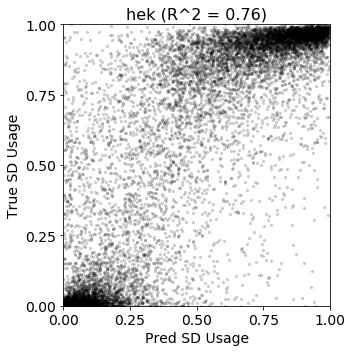

Test set R^2 = 0.77, p = 0.0


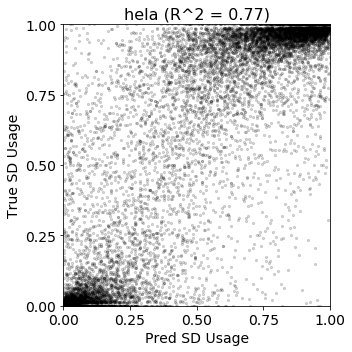

Test set R^2 = 0.75, p = 0.0


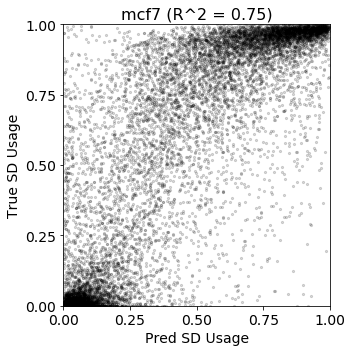

Test set R^2 = 0.78, p = 0.0


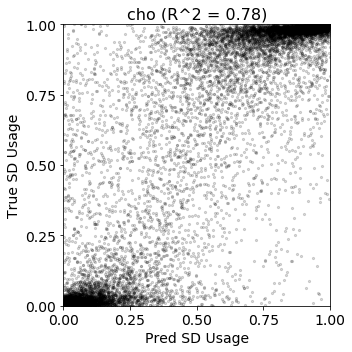

In [6]:
[X_up_test, X_dn_test], [y_hek_test, y_hela_test, y_mcf7_test, y_cho_test] = plasmid_gens['test'][0]
X_test = X_up_test

y_hek_test_pred = get_y_pred(X_test, hek_w, hek_w_0)
y_hela_test_pred = get_y_pred(X_test, hela_w, hela_w_0)
y_mcf7_test_pred = get_y_pred(X_test, mcf7_w, mcf7_w_0)
y_cho_test_pred = get_y_pred(X_test, cho_w, cho_w_0)


test_tuples = [
    ('hek', y_hek_test, y_hek_test_pred),
    ('hela', y_hela_test, y_hela_test_pred),
    ('mcf7', y_mcf7_test, y_mcf7_test_pred),
    ('cho', y_cho_test, y_cho_test_pred)
]

for [cell_type, y_test, y_test_pred] in test_tuples :
    
    #Plot test set scatter
    f = plt.figure(figsize=(5, 5))
    
    r_val, p_val = pearsonr(y_test_pred, y_test)
    print("Test set R^2 = " + str(round(r_val * r_val, 2)) + ", p = " + str(p_val))

    plt.scatter(y_test_pred, y_test, color='black', s=5, alpha=0.15)
    
    plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
    plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
    plt.xlabel('Pred SD Usage', fontsize=14)
    plt.ylabel('True SD Usage', fontsize=14)
    plt.title(str(cell_type) + " (R^2 = " + str(round(r_val * r_val, 2)) + ")", fontsize=16)
    
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    
    plt.tight_layout()
    
    plt.show()



Diff pred R^2 = 0.04, p = 1.1515785787755982e-127


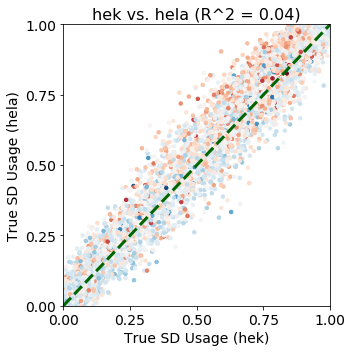

vmin = -0.09413677571695542, vmax = 0.15673637804001372


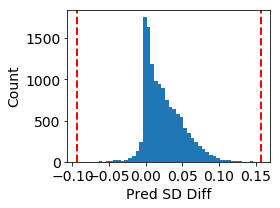

Diff pred R^2 = 0.16, p = 0.0


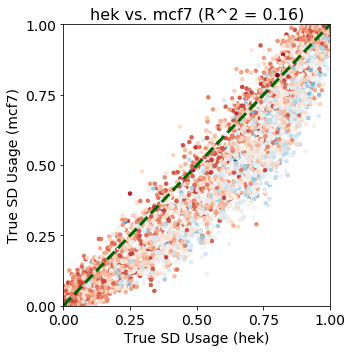

vmin = -0.2423365383726711, vmax = 0.04159717968103116


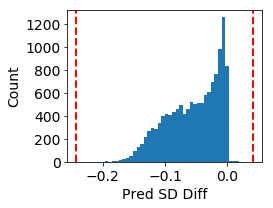

Diff pred R^2 = 0.15, p = 0.0


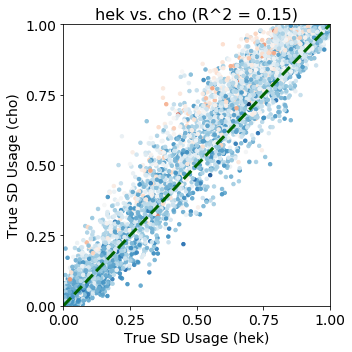

vmin = -0.0824295024608375, vmax = 0.32500437459319775


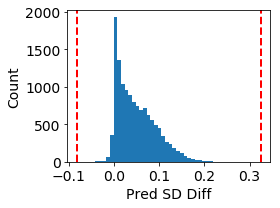

Diff pred R^2 = 0.2, p = 0.0


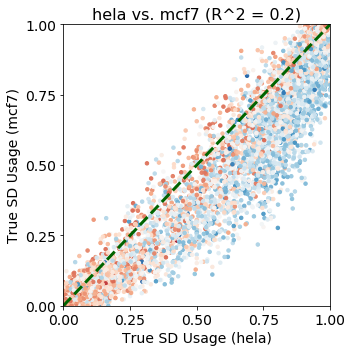

vmin = -0.28884591525481873, vmax = 0.0788837256945106


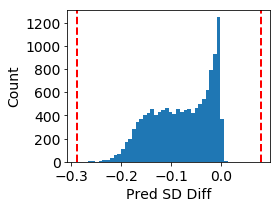

Diff pred R^2 = 0.05, p = 2.646128792456992e-153


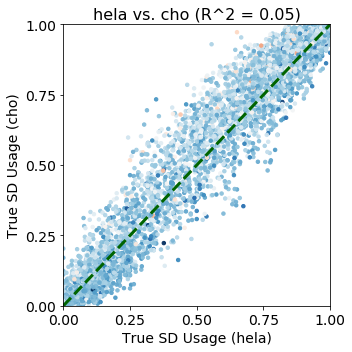

vmin = -0.11244680852904171, vmax = 0.32629404040216975


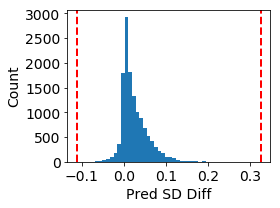

Diff pred R^2 = 0.27, p = 0.0


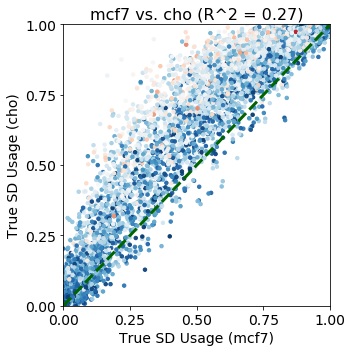

vmin = -0.008516949526140204, vmax = 0.4644118187530927


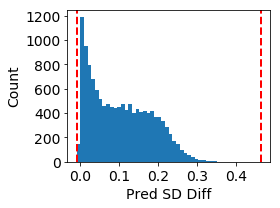

In [11]:

test_tuples = [
    ('hek', y_hek_test, y_hek_test_pred),
    ('hela', y_hela_test, y_hela_test_pred),
    ('mcf7', y_mcf7_test, y_mcf7_test_pred),
    ('cho', y_cho_test, y_cho_test_pred)
]

for cell_1_i in range(0, len(test_tuples)) :
    for cell_2_j in range(cell_1_i + 1, len(test_tuples)) :
        
        [cell_1, y_test_1, y_test_pred_1] = test_tuples[cell_1_i]
        [cell_2, y_test_2, y_test_pred_2] = test_tuples[cell_2_j]


        f = plt.figure(figsize=(5, 5))

        r_val, p_val = pearsonr(y_test_pred_2 - y_test_pred_1, y_test_2 - y_test_1)
        print("Diff pred R^2 = " + str(round(r_val * r_val, 2)) + ", p = " + str(p_val))

        min_delta = np.min(y_test_pred_2 - y_test_pred_1)
        max_delta = np.max(y_test_pred_2 - y_test_pred_1)
        max_abs_delta = np.abs(np.max(y_test_pred_2 - y_test_pred_1))

        plt.scatter(y_test_1, y_test_2, c=y_test_pred_2 - y_test_pred_1, cmap='RdBu_r', vmin=min_delta, vmax=max_delta, s=12, alpha=0.95)

        plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
        plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
        plt.xlabel('True SD Usage (' + cell_1 + ')', fontsize=14)
        plt.ylabel('True SD Usage (' + cell_2 + ')', fontsize=14)
        plt.title(cell_1 + ' vs. ' + cell_2 + " (R^2 = " + str(round(r_val * r_val, 2)) + ")", fontsize=16)

        plt.plot([0, 1], [0, 1], color='darkgreen', linewidth=3, linestyle='--')

        plt.xlim(0, 1)
        plt.ylim(0, 1)

        plt.tight_layout()

        plt.show()
        
        print("vmin = " + str(min_delta) + ", vmax = " + str(max_delta))
        
        f = plt.figure(figsize=(4, 3))
        
        plt.hist(y_test_pred_2 - y_test_pred_1, bins=50)
        
        plt.axvline(x=min_delta, color='red', linewidth=2, linestyle='--')
        plt.axvline(x=max_delta, color='red', linewidth=2, linestyle='--')
        
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel('Pred SD Diff', fontsize=14)
        plt.ylabel('Count', fontsize=14)

        plt.tight_layout()
        plt.show()


Diff pred R^2 = 0.04, p = 1.1515785787755982e-127


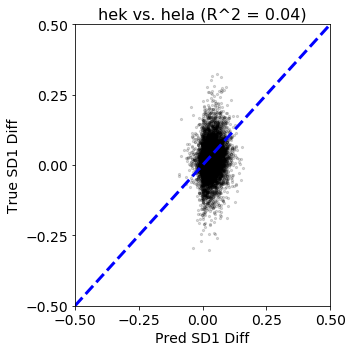

Diff pred R^2 = 0.16, p = 0.0


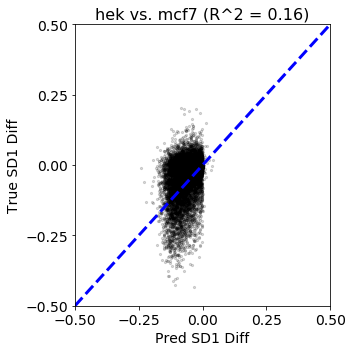

Diff pred R^2 = 0.15, p = 0.0


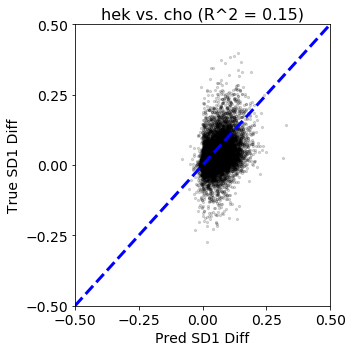

Diff pred R^2 = 0.2, p = 0.0


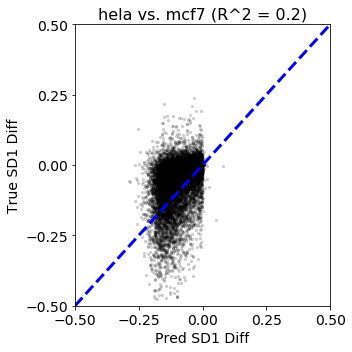

Diff pred R^2 = 0.05, p = 2.646128792456992e-153


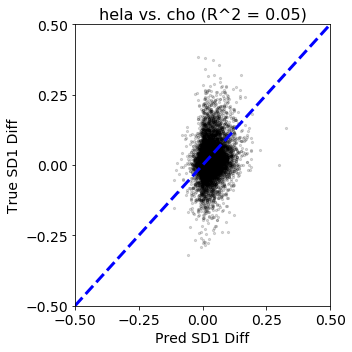

Diff pred R^2 = 0.27, p = 0.0


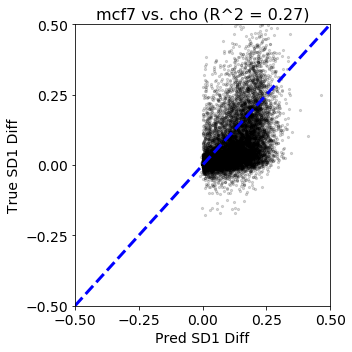

In [9]:

test_tuples = [
    ('hek', y_hek_test, y_hek_test_pred),
    ('hela', y_hela_test, y_hela_test_pred),
    ('mcf7', y_mcf7_test, y_mcf7_test_pred),
    ('cho', y_cho_test, y_cho_test_pred)
]

for cell_1_i in range(0, len(test_tuples)) :
    for cell_2_j in range(cell_1_i + 1, len(test_tuples)) :
        
        [cell_1, y_test_1, y_test_pred_1] = test_tuples[cell_1_i]
        [cell_2, y_test_2, y_test_pred_2] = test_tuples[cell_2_j]


        f = plt.figure(figsize=(5, 5))

        r_val, p_val = pearsonr(y_test_pred_2 - y_test_pred_1, y_test_2 - y_test_1)
        print("Diff pred R^2 = " + str(round(r_val * r_val, 2)) + ", p = " + str(p_val))

        plt.scatter(y_test_pred_2 - y_test_pred_1, y_test_2 - y_test_1, color='black', s=5, alpha=0.15)
        plt.plot([-0.5, 0.5], [-0.5, 0.5], color='blue', linewidth=3, linestyle='--')
        
        plt.xticks([-0.5, -0.25, 0.0, 0.25, 0.5], fontsize=14)
        plt.yticks([-0.5, -0.25, 0.0, 0.25, 0.5], fontsize=14)
        plt.xlabel('Pred SD1 Diff', fontsize=14)
        plt.ylabel('True SD1 Diff', fontsize=14)
        plt.title(cell_1 + ' vs. ' + cell_2 + " (R^2 = " + str(round(r_val * r_val, 2)) + ")", fontsize=16)

        plt.xlim(-0.5, 0.5)
        plt.ylim(-0.5, 0.5)

        plt.tight_layout()

        plt.show()
